In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

def Cnm(n,m):
    return np.exp((1j*np.pi/4)*(1-(-1)**(n+m)))

# Please note that here d is not used as we are taking it to be d=1, which allows us to perform analytics further
def Phi_unit(f,A,d):
    B = 1.0 - 2.0 * A
    ''' Unitary φ-window in frequency domain, sampled at frequencies f, with parameters A and d.'''
    return np.where(np.abs(f)>A+B,f*0,np.where(np.abs(f)>A,np.cos((np.pi/2)*(np.abs(f)-A)/B),f*0+1))

def gnmf(n,m,f,DT,nf,A,d):
    '''Returns the Gabor atom g_{n,m}(f) in frequency domain, sampled at frequencies f, for time shift n and freq shift m.'''
    DF=1/(2*DT)
    return np.where(m==0,np.exp(-4j*np.pi*n*f*DT)*Phi_unit(f/DF,A,d),
             np.where(m==nf,(Phi_unit(f/DF+m,A,d)+Phi_unit(f/DF-m,A,d))*np.exp(-4j*np.pi*n*f*DT),
                    (-1)**(m*n)*(np.conjugate(Cnm(n,m))*Phi_unit(f/DF+m,A,d)+Cnm(n,m)*Phi_unit(f/DF-m,A,d))
                     *np.exp(-2j*np.pi*n*f*DT)/np.sqrt(2)
             ))


def wdm_forward(x, nt, nf, A, d, dt):
    ''' Forward WDM: from time-domain signal x of length nt*nf to W of shape (nt, nf+1) '''

    n_total = nt * nf
    if nt % 2 != 0 or nf % 2 != 0:
        raise ValueError("nt and nf must both be even.")
    if x.shape[-1] != n_total:
        raise ValueError(f"len(x)={x.shape[-1]} must equal nt*nf={n_total}.")
    if not (0 < A < 0.5):
        raise ValueError("A must be in (0, 0.5).")

    # 1) Compute FFT of full signal
    X_fft = fft(x)  # length = n_total

    # 2) Build φ-window of length=nt
    dF_phi = 1.0 / (2.0 * nf * dt)
    fs_full = fftfreq(n_total,dt)  # length = n_total
    half = nt // 2
    fs_phi = np.concatenate([fs_full[:half], fs_full[-half:]])  # length = nt
    phi_window = Phi_unit(fs_phi / dF_phi, A, d) * np.sqrt(2*nf)  # length = nt

    # 3) Prepare output array
    W = np.zeros((nt, nf+1), dtype=float)

    # 4) Handle m=0 separately, since they only involve half of the φ-window
    block=X_fft[1:half]*phi_window[1:half]
    larr=np.arange(1,half)
    narr=np.arange(nt)
    W[:, 0] = np.real(np.sum(np.exp(4j*np.pi*larr[None,:]*narr[:,None]/nt)*block[None,:],axis=1)
                      +X_fft[0]*phi_window[0]/2)/(nt*nf)

    # 5) For each sub-band m=1..nf-1:
    for m in range(1, nf):
        block = np.concatenate([X_fft[int(m*half):int((m+1)*half)], X_fft[int((m-1)*half):int(m*half)]])

        # Multiply by φ-window and IFFT
        xnm_time = ifft(block * phi_window)  # length = nt, complex

        # Real part of conj(C)·xnm_time, scaled by √2/nf
        W[:, m] = (np.sqrt(2.0) / nf) * np.real(np.conj(Cnm(np.arange(nt), m)) * xnm_time)

    # 6) Handle m=nf separately, since they only involve the other half of the φ-window
    block=X_fft[n_total//2-half:n_total//2]*phi_window[-half:]
    larr=np.arange(n_total//2-half,n_total//2)
    narr=np.arange(nt)
    W[:, nf] = np.real(np.sum(np.exp(4j*np.pi*larr[None,:]*narr[:,None]/nt)*block[None,:],axis=1)
                       +X_fft[n_total//2]*phi_window[0]/2)/(nt*nf) 

    return W


def wdm_inverse(W, A, d, dt):
    ''' Inverse WDM: from W of shape (nt, nf+1) to time-domain signal x of length nt*nf '''

    nt, nfp1 = W.shape
    nf = nfp1 - 1

    if nt % 2 != 0 or nf % 2 != 0:
        raise ValueError("nt and nf must both be even.")
    n_total = nt * nf
    if not (0 < A < 0.5):
        raise ValueError("A must be in (0, 0.5).")

    # 1) Build φ-window (same as forward)
    dF_phi = 1.0 / (2.0 * nf * dt)
    fs_full = fftfreq(n_total,dt)
    half = nt // 2
    fs_phi = np.concatenate([fs_full[:half], fs_full[-half:]])
    phi_window = Phi_unit(fs_phi / dF_phi, A, d) * np.sqrt(2*nf)

    # 2) Build C(n,m) and form ylm = C · W / sqrt(2) · nf
    n_idx = np.arange(nt)[:, None]  # shape (nt,1)
    m_idx = np.arange(nf)[None, :]  # shape (1,nf)

    ylm = Cnm(n_idx, m_idx) * W[:, :nf] * nf / np.sqrt(2.0)

    # 3) FFT each column along axis=0
    Y = np.fft.fft(ylm, axis=0)  # shape (nt,nf)

    # 4) Reconstruct full-spectrum X_recon of length n_total
    X_recon = np.zeros(n_total, dtype=complex)

    # 5) Handle m=0 separately, since they only involve half of the φ-window

    narr = np.arange(nt)
    larr = np.arange(1, half)

    X_recon[1:half] += np.sum(W[:,0][:,None]*np.exp(-4j*np.pi*narr[:,None]*larr[None,:]/nt)
                              ,axis=0)*(nf)*phi_window[1:half]
    X_recon[0] += np.sum(W[:, 0]) * (nf) * phi_window[0]/2

    # 6) For each sub-band m=1..nf-1:
    for m in range(1, nf):
        # Build the nt-length “block” in frequency space: Y[:,m] * φ-window
        block = Y[:, m] * phi_window  # length = nt
        X_recon[(m-1)*half:(m+1)*half] += np.concatenate([block[half:], block[:half]])


    # 7) Handle m=Nf separately, since they only involve half of the φ-window
    larr = np.arange(n_total//2 - half, n_total//2)

    X_recon[n_total//2-half:n_total//2] += np.sum(W[:,nf][:,None]*np.exp(-4j*np.pi*narr[:,None]*larr[None,:]/nt)
                                                  ,axis=0)*(nf)*phi_window[-half:]
    X_recon[n_total//2] += np.sum(W[:, nf]) * (nf) * phi_window[0]/2
    

    # 5) IFFT back to time domain
    x_time = ifft(X_recon)
    return np.real(x_time)/(nf/2)


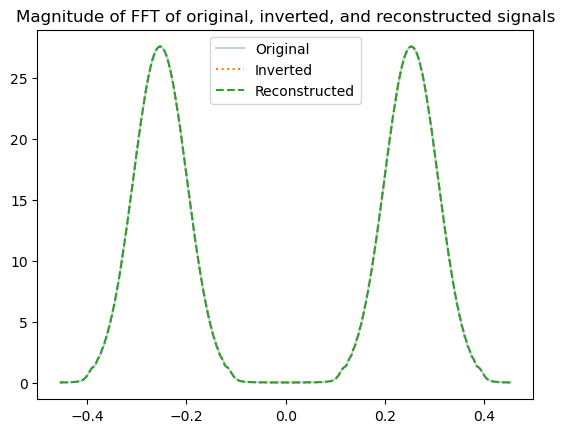

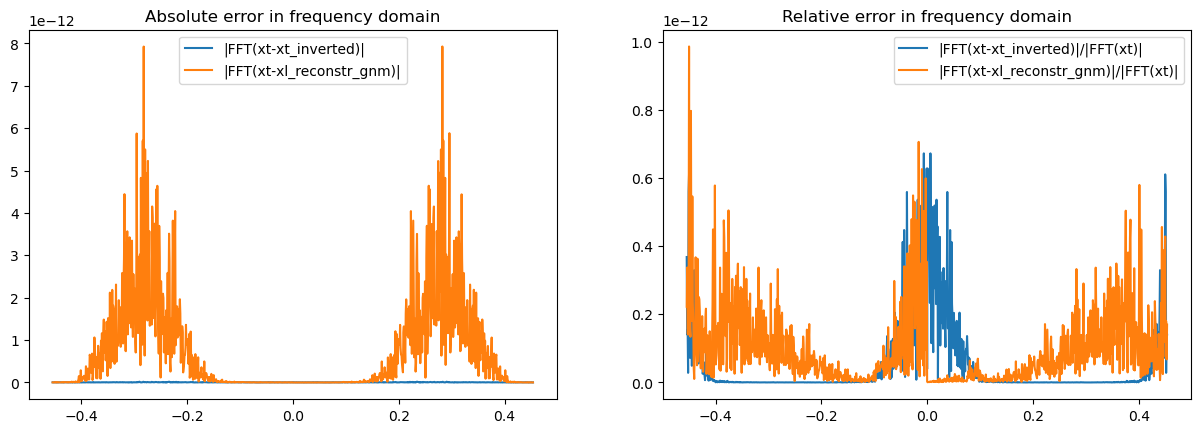

In [2]:
''' Parameters of the signal and WDM'''

N=int(2**10)
Nt=int(2**5)
Nf=int(N/Nt)
dt=1.1 # This number is random, to show that it works for any dt
T=dt*N
df=1/T
DT=Nf*dt
DF=1/(2*DT)
DOm=2*np.pi*DF
times=np.arange(0,N)*dt
freqs=fftfreq(N,dt)

Atry=1/3 # Necula/Cornish/pywavelet use A=1/4 but I found https://en.wikipedia.org/wiki/Meyer_wavelet with A=1/3
         # whose Meyer window has an analytical expression in time domain. I believe we can extend it to A=1/4 too
dtry=1 # d is not used in the current implementation, for the reason here explained above (it allows analytics for the Meyer window)

# Precompute the Gabor atoms g_{n,m}(f) for all n,m and frequencies f, to speed up reconstruction
gnmf_tab = np.zeros((Nt,Nf+1,N))*1j
for n in range(Nt):
    for m in range(Nf+1):
        gnmf_tab[n,m] = gnmf(n,m,freqs,DT,Nf,Atry,dtry)


''' Generating a test signal, applying WDM forward and inverse, and comparing the results in frequency domain.'''

def waveform_sine_example(t):
    return np.sin(2*np.pi*t*0.08)

def waveform_chirplet_example(t,T):
    return np.exp(-(t-T/2)**2/(T/4)**2)*np.cos(2*np.pi*t*(0.1+t*0.153/T)+0.3)

# You can switch between a chirplet and a sine wave by commenting/uncommenting the following lines:
xt=waveform_chirplet_example(times,T)
# xt=waveform_sine_example(times)

wnm = wdm_forward(xt, Nt, Nf, Atry, dtry, dt)
xt_inverted = wdm_inverse(wnm, Atry, dtry, dt)
xl_reconstr_gnm = np.einsum('nm,nmk->k', wnm, gnmf_tab)

''' Test plots comparing the original, inverted, and reconstructed signals in frequency domain.'''

idx = np.argsort(freqs)
plt.plot(freqs[idx],np.abs(fft(xt)[idx]),alpha=0.3,label='Original')
plt.plot(freqs[idx],np.abs(fft(xt_inverted)[idx]),linestyle='dotted',label='Inverted')
plt.plot(freqs[idx],np.abs(xl_reconstr_gnm[idx]*np.sqrt(Nf*2)),linestyle='dashed',label='Reconstructed')
plt.legend()
plt.title('Magnitude of FFT of original, inverted, and reconstructed signals')
plt.show()

idx = np.argsort(freqs)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.plot(freqs[idx],np.abs(fft(xt-xt_inverted)[idx]),label='|FFT(xt-xt_inverted)|')
ax1.plot(freqs[idx],np.abs(fft(xt)[idx]-xl_reconstr_gnm[idx]*np.sqrt(Nf*2)),label='|FFT(xt-xl_reconstr_gnm)|')
ax2.plot(freqs[idx],np.abs(fft(xt-xt_inverted)[idx])/np.abs(fft(xt)[idx]),label='|FFT(xt-xt_inverted)|/|FFT(xt)|')
ax2.plot(freqs[idx],np.abs(fft(xt)[idx]-xl_reconstr_gnm[idx]*np.sqrt(Nf*2))/np.abs(fft(xt)[idx]),label='|FFT(xt-xl_reconstr_gnm)|/|FFT(xt)|')
ax1.legend()
ax2.legend()
ax1.set_title('Absolute error in frequency domain')
ax2.set_title('Relative error in frequency domain')
plt.show()

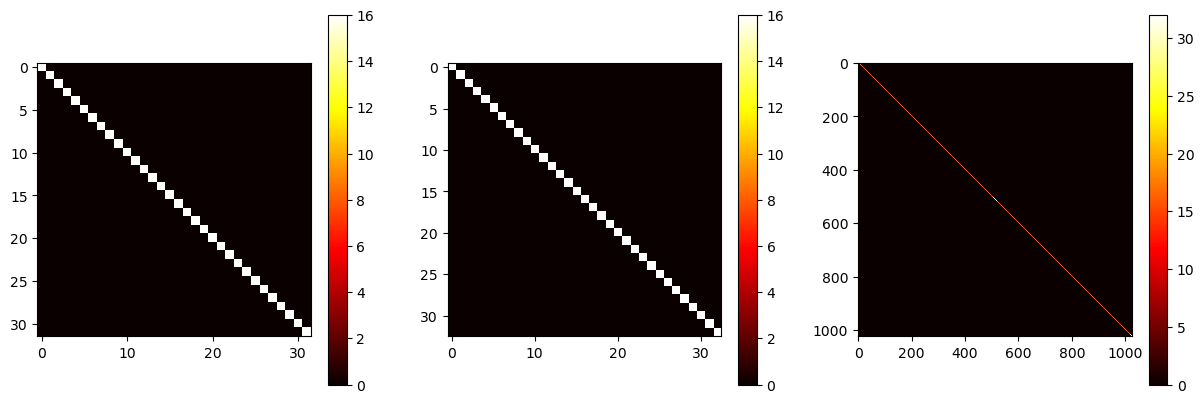

In [3]:
''' Tests of the orthogonality properties of the Gabor atoms, which are the basis functions of the WDM.'''
mfix_test=1
mfix_naxgrid=np.einsum('nk,lk->nl', gnmf_tab[:,mfix_test,:], np.conjugate(gnmf_tab[:,mfix_test,:]))
nfix_test=16
nfix_maxgrid=np.einsum('mk,lk->ml', gnmf_tab[nfix_test], np.conjugate(gnmf_tab[nfix_test]))
taxgrid=np.einsum('nmk,nml->kl', gnmf_tab, np.conjugate(gnmf_tab))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
im1=ax1.imshow(np.abs(mfix_naxgrid), cmap='hot', interpolation='nearest')
im2=ax2.imshow(np.abs(nfix_maxgrid), cmap='hot', interpolation='nearest')
im3=ax3.imshow(np.abs(taxgrid), cmap='hot', interpolation='nearest')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()
